In [229]:
import pandas as pd
import numpy as np
from os import path
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import shap

In [230]:
data_file = "processed_ohe_True_selected_columns_95_zoonosis_dataset_full.csv"
one_hot_encoded = "True" in data_file

In [231]:
# Load separate issues
# X = pd.read_csv(
#     path.join("..", "cleaned_data", "x_significant_top_pcas.csv"), index_col=0
# )
# y = pd.read_csv(
#     path.join("..", "cleaned_data", "y_significant_top_pcas.csv"), index_col=0
# )

In [232]:
df = pd.read_csv(path.join("..", "cleaned_data", data_file))
df.drop_duplicates(inplace=True)
y = df["label"]
X = df.drop(columns=["label"])

In [233]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [234]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

In [235]:
models = [
    ("XGBoost", XGBClassifier(enable_categorical=True)),
    ("Random Forest", RandomForestClassifier()),
    ("Ridge Classifier", RidgeClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Support Vector Classification", SVC()),
    # ("LightGBM", LGBMClassifier()),
    ("KNN", KNeighborsClassifier(5, weights="uniform")),
    ("Naive Bayes", GaussianNB()),
    ("Neural Network", MLPClassifier()),
    ("Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis()),
]

In [236]:
# min_error = float("inf")

# for name, model in models:
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     rmsle_score = rmsle(y_test, y_pred)

#     if rmsle_score < min_error:
#         min_error = rmsle_score
#         best_model = (name, model)

#     print(f"{name}: RMSLE = {rmsle_score}")
# print(best_model[0])

## Plot Model Performance

In [237]:
def get_feature_importance(model, X):
    try:
        mdi_importances = pd.Series(
            model.feature_importances_, index=X.columns
        ).sort_values(ascending=True)
        return mdi_importances
    except AttributeError:
        pass


def get_permutation_importance(model, X, y):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    # Create a Series with feature names and their mean importances
    importances = pd.Series(result.importances_mean, index=X.columns)
    # Sort importances from most to least important
    sorted_importances = importances.sort_values(ascending=False)
    return sorted_importances

In [238]:
def get_results_all_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        average_precision = average_precision_score(y_test, y_pred)
        results[name] = {
            "accuracy": accuracy,
            "roc_auc": roc_auc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "average_precision": average_precision,
        }
    return results

In [239]:
results = get_results_all_models(models, X_train, X_test, y_train, y_test)

/Users/austinandrews/Projects/ukase_data_challenge/.venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/austinandrews/Projects/ukase_data_challenge/.venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [240]:
def plot_model_results(results):

    names = []
    accuracies = []
    roc_auc_curves = []
    precisions = []
    recalls = []
    f1s = []
    average_precisions = []
    for name, result in results.items():
        names.append(name)
        accuracies.append(result["accuracy"])
        roc_auc_curves.append(result["roc_auc"])
        precisions.append(result["precision"])
        recalls.append(result["recall"])
        f1s.append(result["f1"])
        average_precisions.append(result["average_precision"])

    X_axis = np.arange(len(names))

    plt.bar(X_axis - 0.3, accuracies, 0.1, label="Accuracies")
    plt.bar(X_axis - 0.2, roc_auc_curves, 0.1, label="ROC AUC")
    plt.bar(X_axis - 0.1, precisions, 0.1, label="Precision")
    plt.bar(X_axis + 0.0, recalls, 0.1, label="Recall")
    plt.bar(X_axis + 0.1, f1s, 0.1, label="F1")
    plt.bar(X_axis + 0.2, average_precisions, 0.1, label="Avg Precision")

    plt.xticks(X_axis, names, rotation=90)
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title("Metrics of Different Models")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

In [241]:
results

{'XGBoost': {'accuracy': 0.9900183871815077,
  'roc_auc': np.float64(0.8687988752984925),
  'precision': 0.9263157894736842,
  'recall': 0.7394957983193278,
  'f1': 0.822429906542056,
  'average_precision': np.float64(0.6931495289003577)},
 'Random Forest': {'accuracy': 0.9892303651168899,
  'roc_auc': np.float64(0.839929409941851),
  'precision': 0.9642857142857143,
  'recall': 0.680672268907563,
  'f1': 0.7980295566502463,
  'average_precision': np.float64(0.6663441578364996)},
 'Ridge Classifier': {'accuracy': 0.9842395587076438,
  'roc_auc': np.float64(0.7641635830037004),
  'precision': 0.9402985074626866,
  'recall': 0.5294117647058824,
  'f1': 0.6774193548387096,
  'average_precision': np.float64(0.5125148373923273)},
 'Decision Tree': {'accuracy': 0.983451536643026,
  'roc_auc': np.float64(0.8532111868608615),
  'precision': 0.7456140350877193,
  'recall': 0.7142857142857143,
  'f1': 0.7296137339055794,
  'average_precision': np.float64(0.5415123703664204)},
 'Support Vector Cl

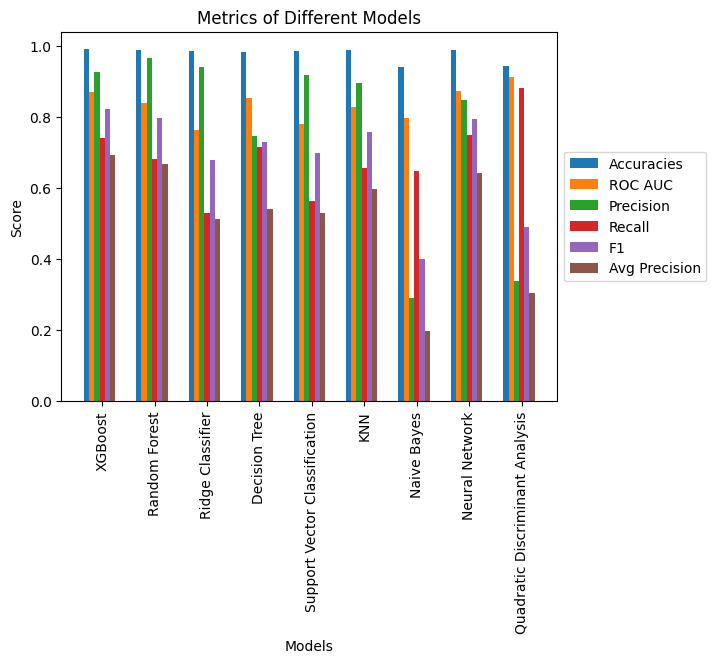

In [242]:
plot_model_results(results)

In [243]:
results_to_be_saved = pd.DataFrame.from_dict(data=results, orient="index")
results_to_be_saved.to_csv(path.join("..", "model_comparison_data_presentation", "random_dataset.csv"))

In [202]:
results_to_be_saved.to_excel(
    path.join("..", "model_comparison_data", "annasselection_results_2.xlsx")
)

## Feature importance of best performing algorthims

In [203]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [204]:
def plot_feature_importance(model, X):

    mdi_importances = pd.Series(
        model.feature_importances_, index=X.columns
    ).sort_values(ascending=True)
    ax = mdi_importances.plot.barh()
    ax.set_title("Decision Tree Feature Importances (MDI)")
    ax.figure.tight_layout()

In [205]:
def plot_permutation_importance(model, X, y):
    result = permutation_importance(
        model, X, y, n_repeats=10, random_state=42, n_jobs=2
    )

    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()

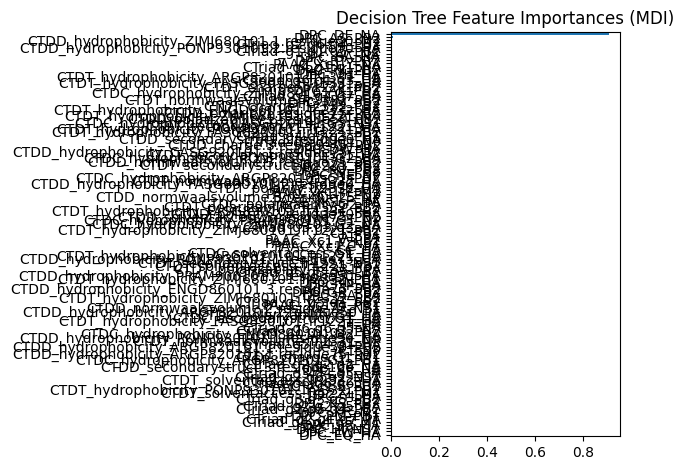

In [206]:
plot_feature_importance(model, X)

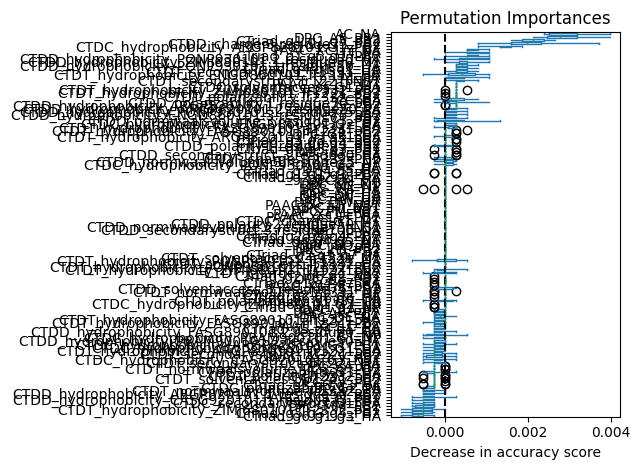

In [207]:
plot_permutation_importance(model, X_test, y_test)

## Shapley plots of best performing algorithms

In [208]:
def get_shap_values(model, X, sample_index=10, class_index=1):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap_sample = shap_values[sample_index].values
    if shap_sample.ndim == 2:
        shap_sample = shap_sample[:, class_index]
    return pd.Series(shap_sample, index=X.columns)

In [209]:
# explainer = shap.Explainer(model, X_test)
# explanation = explainer(X)
# shap_values = explanation.values
# shap_values_mean = shap_values.mean(axis=0)
# shap_values_mean, X.columns
# indexed_shap_values = pd.Series(shap_values_mean, index=X.columns)
# indexed_shap_values
# shap_sample = shap_values.values
# shap_sample.values

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
# shap_importance = (
#     pd.Series(shap_values.values.mean(axis=0), X.columns)
#     .abs()
#     .sort_values(ascending=False)
# )

pd.DataFrame(shap_values.values[0], index=X.columns)

,0
AC_NA,0.019681
CT_NP,-0.068412
TT_PA,-0.091653
CTDC_hydrophobicity_PONP930101.G2_HA,0.017691
CTDC_hydrophobicity_ENGD860101.G2_HA,-0.024069
...,...
CT_PB1,0.025001
CTriad_g1.g1.g5_PB2,-0.141737
PAAC_Xc1.C_PA,-0.093626
PAAC_Xc1.D_PB1,-0.053999


In [210]:
# results_to_be_saved["shap"]["Decision Tree"] = get_shap_values(model, X_test, y_test)
get_shap_values(model, X_test)

AC_NA                                   0.188429
CT_NP                                   0.114962
TT_PA                                  -0.016335
CTDC_hydrophobicity_PONP930101.G2_HA   -0.021060
CTDC_hydrophobicity_ENGD860101.G2_HA    0.018863
                                          ...   
CT_PB1                                  0.078188
CTriad_g1.g1.g5_PB2                    -0.094801
PAAC_Xc1.C_PA                           0.053412
PAAC_Xc1.D_PB1                          0.146299
PAAC_Xc1.V_PB2                         -0.060027
Length: 124, dtype: float64

In [211]:
def shapley_waterfall(model):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.waterfall(shap_values[0], max_display=14)


def shapley_beeswarm(model):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values)


def shapley_heatmap(model):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.heatmap(shap_values[:1000])

In [212]:
shapley_waterfall(model)

PermutationExplainer explainer:  28%|██▊       | 5341/18851 [08:09<21:03, 10.69it/s]


KeyboardInterrupt: 

PermutationExplainer explainer: 18530it [20:38, 14.81it/s]                           


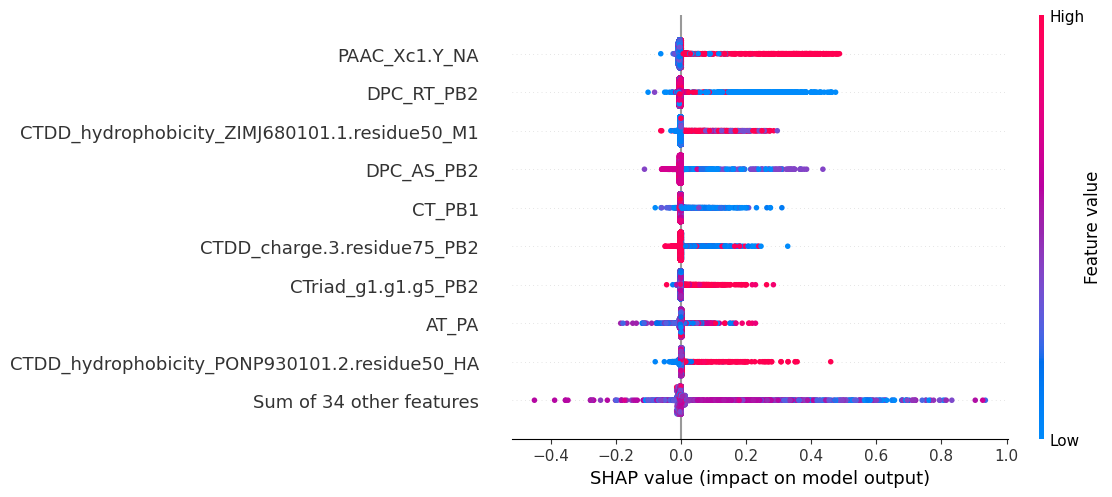

In [ ]:
shapley_beeswarm(model)

PermutationExplainer explainer: 18530it [2:07:45,  2.40it/s]                                


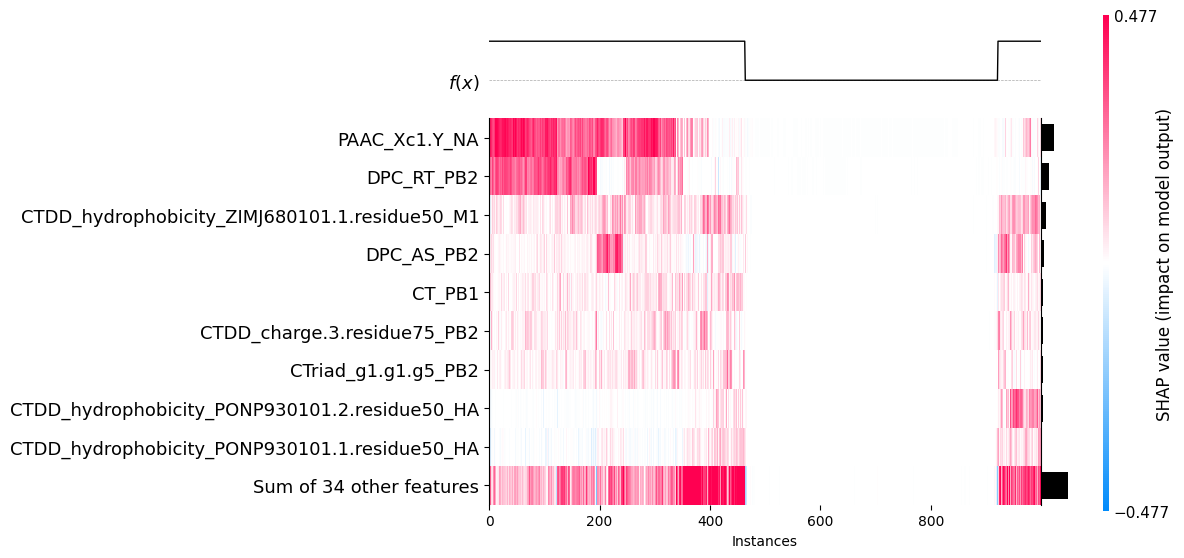

In [ ]:
shapley_heatmap(model)